# Using trained model with Twitter API

In [1]:
import requests
import pandas as pd
import json
import ast
import yaml
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:

# Twitter URL
def create_twitter_url():
    handle = "racism"
    max_results = 100
    mrf = "max_results={}".format(max_results)
    q = "query={}".format(handle)
    url = "https://api.twitter.com/2/tweets/search/recent?{}&{}".format(
        mrf, q
    )
    return url



In [3]:
# Authenticating and connecting to the Twitter API
def process_yaml():
    with open("config.yaml") as file: #This File containes bearer_token from twitter API
        return yaml.safe_load(file)


def create_bearer_token(data):
    return data["search_tweets_api"]["bearer_token"]


def twitter_auth_and_connect(bearer_token, url):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [4]:
# Generating languages
def lang_data_shape(res_json):
    data_only = res_json["data"]
    doc_start = '"documents": {}'.format(data_only)
    str_json = "{" + doc_start + "}"
    dump_doc = json.dumps(str_json)
    doc = json.loads(dump_doc)
    return ast.literal_eval(doc)

In [5]:
url = create_twitter_url()
data = process_yaml()
bearer_token = create_bearer_token(data)
res_json = twitter_auth_and_connect(bearer_token, url)
# print(res_json)
documents = lang_data_shape(res_json)


In [6]:
df = pd.DataFrame.from_dict(documents['documents'])

In [7]:
df.drop(columns='id',inplace=True)
df.rename(columns={'text':'tweet'},inplace=True)
df.head()

,tweet
0,RT @Lawrence: “I was shocked that a corporate ...
1,RT @makokaazo: Fellow Whites:\n\nBIPOC aren't ...
2,RT @MicaBurton: The fear PoC experience when s...
3,Racism but I know that’s not the answer you’re...
4,RT @HerSoulWrites: Environmental Racism. Fun f...


### Data Preprocessing Steps

In [8]:
def remove_pattern(input_text,pattern):
    r= re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text
                          

### Removing Handles

In [9]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'],"@[\w]*") 
df.head(10)

,tweet,tidy_tweet
0,RT @Lawrence: “I was shocked that a corporate ...,RT : “I was shocked that a corporate head woul...
1,RT @makokaazo: Fellow Whites:\n\nBIPOC aren't ...,RT : Fellow Whites:\n\nBIPOC aren't lying to y...
2,RT @MicaBurton: The fear PoC experience when s...,RT : The fear PoC experience when speaking out...
3,Racism but I know that’s not the answer you’re...,Racism but I know that’s not the answer you’re...
4,RT @HerSoulWrites: Environmental Racism. Fun f...,RT : Environmental Racism. Fun fact: we have l...
5,RT @TeaPainUSA: Racists desperately search for...,RT : Racists desperately search for anything t...
6,RT @sleeannn18: I think I understand how racis...,RT : I think I understand how racism affects e...
7,RT @VoLinxx: It's a privilege to learn about \...,RT : It's a privilege to learn about \nracism ...
8,@azzzzyb So much racism imo,So much racism imo
9,"@VoLinxx Wow, talk about anti-white racism. L...","Wow, talk about anti-white racism. Last I ch..."


In [10]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
df.head(10)

,tweet,tidy_tweet
0,RT @Lawrence: “I was shocked that a corporate ...,RT I was shocked that a corporate head woul...
1,RT @makokaazo: Fellow Whites:\n\nBIPOC aren't ...,RT Fellow Whites BIPOC aren t lying to you...
2,RT @MicaBurton: The fear PoC experience when s...,RT The fear PoC experience when speaking out...
3,Racism but I know that’s not the answer you’re...,Racism but I know that s not the answer you re...
4,RT @HerSoulWrites: Environmental Racism. Fun f...,RT Environmental Racism Fun fact we have l...
5,RT @TeaPainUSA: Racists desperately search for...,RT Racists desperately search for anything t...
6,RT @sleeannn18: I think I understand how racis...,RT I think I understand how racism affects e...
7,RT @VoLinxx: It's a privilege to learn about \...,RT It s a privilege to learn about racism i...
8,@azzzzyb So much racism imo,So much racism imo
9,"@VoLinxx Wow, talk about anti-white racism. L...",Wow talk about anti white racism Last I ch...


## Removing short words (a,is,so etc..)

In [11]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing words whose length is less than 3

In [12]:
df.head()

,tweet,tidy_tweet
0,RT @Lawrence: “I was shocked that a corporate ...,shocked that corporate head would words like t...
1,RT @makokaazo: Fellow Whites:\n\nBIPOC aren't ...,Fellow Whites BIPOC aren lying about racism wo...
2,RT @MicaBurton: The fear PoC experience when s...,fear experience when speaking against speaking...
3,Racism but I know that’s not the answer you’re...,Racism know that answer looking https tDRNoozVBG
4,RT @HerSoulWrites: Environmental Racism. Fun f...,Environmental Racism fact have less trees neig...


In [13]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x:x.split()) #it will split all words by whitespace
tokenized_tweet.head()

0    [shocked, that, corporate, head, would, words,...
1    [Fellow, Whites, BIPOC, aren, lying, about, ra...
2    [fear, experience, when, speaking, against, sp...
3    [Racism, know, that, answer, looking, https, t...
4    [Environmental, Racism, fact, have, less, tree...
Name: tidy_tweet, dtype: object

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #it will stemmatized all words in tweet

In [15]:
#now let's combine these tokens back

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) #concat all words into one sentence
df['tidy_tweet'] = tokenized_tweet

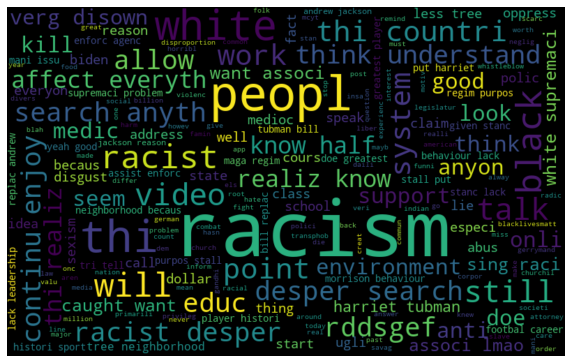

In [16]:
all_words = ' '.join([text for text in df['tidy_tweet']]) 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig("images/WordCloud.png")
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from joblib import dump, load


In [18]:
voc= load('voc.joblib')
model_naive = load('model_naive.joblib')

In [19]:
#Bag-of-words

#Each row in matrix M contains the frequency of tokens(words) in the document D(i)

bow_vectorizer = TfidfVectorizer(max_df=0.90 ,min_df=2 , max_features=1000,stop_words='english',vocabulary=voc)
bow = bow_vectorizer.fit_transform(df['tidy_tweet']) # tokenize and build vocabulary
bow.shape

(100, 1000)

In [20]:
predicted_naive = model_naive.predict(bow)

In [21]:
predicted_naive

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])